In [4]:
import time
from tqdm import tqdm
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

class CustomClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        return x
    
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', ignore_mismatched_sizes=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [5]:
# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

input_dim = model.classifier.in_features
num_classes = 7
model.classifier = CustomClassifier(input_dim, num_classes)
model.classifier.to(device)

'''
for param in model.vit.parameters():
    param.requires_grad = True
'''

optimizer = optim.Adam(model.classifier.parameters(), lr=2e-4) # try 0.01 0.001
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Define a schedule to unfreeze layers gradually
unfreeze_schedule = {
    2: 'vit.encoder.layer.11',
    4: 'vit.encoder.layer.10',
    6: 'vit.encoder.layer.9',
    8: 'vit.encoder.layer.8',
    10: 'vit.encoder.layer.7',
    12: 'vit.encoder.layer.6',
    14: 'vit.encoder.layer.5',
    16: 'vit.encoder.layer.4',
    18: 'vit.encoder.layer.3',
}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset = datasets.ImageFolder(root='archive/train', transform=transform)
test_dataset = datasets.ImageFolder(root='archive/test', transform=transform)

class_counts = {"angry": 3995, "disgust": 436, "fear": 4097, "happy": 7215, "neutral": 4965, "sad": 4830, "surprise":3171}

weights = [1.0 / counts for counts in class_counts.values()]
labels = train_dataset.classes
sample_weights = [weights[label] for _, label in train_dataset.samples]

# Create sampler and DataLoader for training
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, sampler=sampler, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc='Training')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    progress_bar = tqdm(dataloader, desc='Evaluating')
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# Lists to store metrics
train_losses = []
val_losses = []
lr_list = []

num_epochs = 24
best_val_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, device)

    # Gradually unfreeze layers
    if epoch in unfreeze_schedule:
        for name, param in model.named_parameters():
            if unfreeze_schedule[epoch] in name:
                param.requires_grad = True
                print(f'Unfroze layer: {name}')
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

    val_loss, val_accuracy = evaluate(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lr_list.append(optimizer.param_groups[0]['lr'])
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Time: {epoch_duration:.2f}s")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print('-' * 30)
    
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'vit_fer2013_v1_6-6-upscale.pth') #test 1 unfroze 4 layer from head, test 2 unfroze 9 layers
        print(f"Model saved with validation loss: {val_loss:.4f}")

print(f"Best model saved with validation loss: {best_val_loss:.4f}")

Evaluating: 100%|██████████| 225/225 [01:16<00:00,  2.93it/s, loss=0.656]
c:\Users\zln92\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/24
Time: 325.81s
Train Loss: 1.6907
Validation Loss: 1.3251
Validation Accuracy: 0.5007
------------------------------
Model saved with validation loss: 1.3251


Evaluating: 100%|██████████| 225/225 [01:12<00:00,  3.12it/s, loss=0.577]


Epoch 2/24
Time: 316.38s
Train Loss: 1.3835
Validation Loss: 1.2371
Validation Accuracy: 0.5327
------------------------------
Model saved with validation loss: 1.2371


Training: 100%|██████████| 898/898 [03:25<00:00,  4.38it/s, loss=2.07] 


Unfroze layer: vit.encoder.layer.11.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.11.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.11.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.11.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.11.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.11.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.11.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.11.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.11.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.11.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.11.output.dense.weight
Unfroze layer: vit.encoder.layer.11.output.dense.bias
Unfroze layer: vit.encoder.layer.11.layernorm_before.weight
Unfroze layer: vit.encoder.layer.11.layernorm_before.bias
Unfroze layer: vit.encoder.layer.11.layernorm_after.weight
Unfroze layer: vit.encoder.layer.11.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.40it/s, loss=0.582]


Epoch 3/24
Time: 246.74s
Train Loss: 1.2722
Validation Loss: 1.1643
Validation Accuracy: 0.5699
------------------------------
Model saved with validation loss: 1.1643


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.39it/s, loss=0.605]


Epoch 4/24
Time: 249.56s
Train Loss: 1.1871
Validation Loss: 1.1511
Validation Accuracy: 0.5762
------------------------------
Model saved with validation loss: 1.1511


Training: 100%|██████████| 898/898 [03:18<00:00,  4.53it/s, loss=1.16] 


Unfroze layer: vit.encoder.layer.10.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.10.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.10.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.10.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.10.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.10.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.10.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.10.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.10.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.10.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.10.output.dense.weight
Unfroze layer: vit.encoder.layer.10.output.dense.bias
Unfroze layer: vit.encoder.layer.10.layernorm_before.weight
Unfroze layer: vit.encoder.layer.10.layernorm_before.bias
Unfroze layer: vit.encoder.layer.10.layernorm_after.weight
Unfroze layer: vit.encoder.layer.10.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.40it/s, loss=0.607]


Epoch 5/24
Time: 239.67s
Train Loss: 1.1439
Validation Loss: 1.1303
Validation Accuracy: 0.5811
------------------------------
Model saved with validation loss: 1.1303


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.36it/s, loss=0.604]


Epoch 6/24
Time: 259.81s
Train Loss: 1.1030
Validation Loss: 1.1115
Validation Accuracy: 0.5907
------------------------------
Model saved with validation loss: 1.1115


Training: 100%|██████████| 898/898 [03:34<00:00,  4.18it/s, loss=1.02] 


Unfroze layer: vit.encoder.layer.9.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.9.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.9.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.9.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.9.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.9.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.9.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.9.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.9.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.9.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.9.output.dense.weight
Unfroze layer: vit.encoder.layer.9.output.dense.bias
Unfroze layer: vit.encoder.layer.9.layernorm_before.weight
Unfroze layer: vit.encoder.layer.9.layernorm_before.bias
Unfroze layer: vit.encoder.layer.9.layernorm_after.weight
Unfroze layer: vit.encoder.layer.9.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.38it/s, loss=0.479]


Epoch 7/24
Time: 256.46s
Train Loss: 1.0741
Validation Loss: 1.0893
Validation Accuracy: 0.6002
------------------------------
Model saved with validation loss: 1.0893


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.36it/s, loss=0.535]


Epoch 8/24
Time: 278.15s
Train Loss: 1.0119
Validation Loss: 1.0565
Validation Accuracy: 0.6078
------------------------------
Model saved with validation loss: 1.0565


Training: 100%|██████████| 898/898 [03:55<00:00,  3.82it/s, loss=1.21] 


Unfroze layer: vit.encoder.layer.8.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.8.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.8.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.8.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.8.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.8.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.8.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.8.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.8.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.8.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.8.output.dense.weight
Unfroze layer: vit.encoder.layer.8.output.dense.bias
Unfroze layer: vit.encoder.layer.8.layernorm_before.weight
Unfroze layer: vit.encoder.layer.8.layernorm_before.bias
Unfroze layer: vit.encoder.layer.8.layernorm_after.weight
Unfroze layer: vit.encoder.layer.8.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.37it/s, loss=0.519]


Epoch 9/24
Time: 277.23s
Train Loss: 0.9673
Validation Loss: 1.0403
Validation Accuracy: 0.6124
------------------------------
Model saved with validation loss: 1.0403


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.37it/s, loss=0.579]


Epoch 10/24
Time: 299.44s
Train Loss: 0.9258
Validation Loss: 1.0228
Validation Accuracy: 0.6194
------------------------------
Model saved with validation loss: 1.0228


Training: 100%|██████████| 898/898 [04:17<00:00,  3.48it/s, loss=1.3]  


Unfroze layer: vit.encoder.layer.7.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.7.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.7.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.7.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.7.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.7.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.7.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.7.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.7.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.7.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.7.output.dense.weight
Unfroze layer: vit.encoder.layer.7.output.dense.bias
Unfroze layer: vit.encoder.layer.7.layernorm_before.weight
Unfroze layer: vit.encoder.layer.7.layernorm_before.bias
Unfroze layer: vit.encoder.layer.7.layernorm_after.weight
Unfroze layer: vit.encoder.layer.7.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:42<00:00,  5.33it/s, loss=0.422]


Epoch 11/24
Time: 299.90s
Train Loss: 0.8684
Validation Loss: 1.0134
Validation Accuracy: 0.6280
------------------------------
Model saved with validation loss: 1.0134


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.00it/s, loss=0.69] 


Epoch 12/24
Time: 290.11s
Train Loss: 0.8160
Validation Loss: 1.0060
Validation Accuracy: 0.6342
------------------------------
Model saved with validation loss: 1.0060


Training: 100%|██████████| 898/898 [04:37<00:00,  3.24it/s, loss=0.468]


Unfroze layer: vit.encoder.layer.6.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.6.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.6.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.6.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.6.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.6.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.6.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.6.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.6.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.6.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.6.output.dense.weight
Unfroze layer: vit.encoder.layer.6.output.dense.bias
Unfroze layer: vit.encoder.layer.6.layernorm_before.weight
Unfroze layer: vit.encoder.layer.6.layernorm_before.bias
Unfroze layer: vit.encoder.layer.6.layernorm_after.weight
Unfroze layer: vit.encoder.layer.6.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:42<00:00,  5.29it/s, loss=0.497]


Epoch 13/24
Time: 319.66s
Train Loss: 0.7588
Validation Loss: 1.0092
Validation Accuracy: 0.6407
------------------------------


Evaluating: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s, loss=0.496]


Epoch 14/24
Time: 340.85s
Train Loss: 0.7035
Validation Loss: 1.0298
Validation Accuracy: 0.6452
------------------------------


Training: 100%|██████████| 898/898 [04:58<00:00,  3.01it/s, loss=0.829]


Unfroze layer: vit.encoder.layer.5.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.5.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.5.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.5.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.5.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.5.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.5.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.5.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.5.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.5.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.5.output.dense.weight
Unfroze layer: vit.encoder.layer.5.output.dense.bias
Unfroze layer: vit.encoder.layer.5.layernorm_before.weight
Unfroze layer: vit.encoder.layer.5.layernorm_before.bias
Unfroze layer: vit.encoder.layer.5.layernorm_after.weight
Unfroze layer: vit.encoder.layer.5.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:42<00:00,  5.27it/s, loss=0.604]


Epoch 15/24
Time: 341.36s
Train Loss: 0.6456
Validation Loss: 1.0578
Validation Accuracy: 0.6461
------------------------------


Evaluating: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s, loss=0.427]


Epoch 16/24
Time: 363.20s
Train Loss: 0.5792
Validation Loss: 1.1034
Validation Accuracy: 0.6482
------------------------------


Training: 100%|██████████| 898/898 [05:21<00:00,  2.80it/s, loss=0.928]


Unfroze layer: vit.encoder.layer.4.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.4.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.4.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.4.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.4.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.4.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.4.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.4.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.4.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.4.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.4.output.dense.weight
Unfroze layer: vit.encoder.layer.4.output.dense.bias
Unfroze layer: vit.encoder.layer.4.layernorm_before.weight
Unfroze layer: vit.encoder.layer.4.layernorm_before.bias
Unfroze layer: vit.encoder.layer.4.layernorm_after.weight
Unfroze layer: vit.encoder.layer.4.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s, loss=0.826]


Epoch 17/24
Time: 363.59s
Train Loss: 0.5280
Validation Loss: 1.1195
Validation Accuracy: 0.6503
------------------------------


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.49it/s, loss=0.893]


Epoch 18/24
Time: 382.63s
Train Loss: 0.4673
Validation Loss: 1.1830
Validation Accuracy: 0.6566
------------------------------


Training: 100%|██████████| 898/898 [05:38<00:00,  2.65it/s, loss=0.206]


Unfroze layer: vit.encoder.layer.3.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.3.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.3.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.3.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.3.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.3.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.3.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.3.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.3.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.3.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.3.output.dense.weight
Unfroze layer: vit.encoder.layer.3.output.dense.bias
Unfroze layer: vit.encoder.layer.3.layernorm_before.weight
Unfroze layer: vit.encoder.layer.3.layernorm_before.bias
Unfroze layer: vit.encoder.layer.3.layernorm_after.weight
Unfroze layer: vit.encoder.layer.3.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s, loss=0.634]


Epoch 19/24
Time: 379.77s
Train Loss: 0.3888
Validation Loss: 1.2689
Validation Accuracy: 0.6521
------------------------------


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.47it/s, loss=0.786]


Epoch 20/24
Time: 401.82s
Train Loss: 0.3518
Validation Loss: 1.3196
Validation Accuracy: 0.6608
------------------------------


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.49it/s, loss=1.14] 


Epoch 21/24
Time: 401.55s
Train Loss: 0.3030
Validation Loss: 1.3866
Validation Accuracy: 0.6640
------------------------------


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.49it/s, loss=1]    


Epoch 22/24
Time: 401.20s
Train Loss: 0.2568
Validation Loss: 1.4920
Validation Accuracy: 0.6559
------------------------------


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.49it/s, loss=0.809]


Epoch 23/24
Time: 401.30s
Train Loss: 0.2240
Validation Loss: 1.5543
Validation Accuracy: 0.6643
------------------------------


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.47it/s, loss=1.53] 

Epoch 24/24
Time: 401.96s
Train Loss: 0.1981
Validation Loss: 1.6378
Validation Accuracy: 0.6656
------------------------------
Best model saved with validation loss: 1.0060


In [6]:
for name, param in model.named_parameters():
    print(name)

vit.embeddings.cls_token
vit.embeddings.position_embeddings
vit.embeddings.patch_embeddings.projection.weight
vit.embeddings.patch_embeddings.projection.bias
vit.encoder.layer.0.attention.attention.query.weight
vit.encoder.layer.0.attention.attention.query.bias
vit.encoder.layer.0.attention.attention.key.weight
vit.encoder.layer.0.attention.attention.key.bias
vit.encoder.layer.0.attention.attention.value.weight
vit.encoder.layer.0.attention.attention.value.bias
vit.encoder.layer.0.attention.output.dense.weight
vit.encoder.layer.0.attention.output.dense.bias
vit.encoder.layer.0.intermediate.dense.weight
vit.encoder.layer.0.intermediate.dense.bias
vit.encoder.layer.0.output.dense.weight
vit.encoder.layer.0.output.dense.bias
vit.encoder.layer.0.layernorm_before.weight
vit.encoder.layer.0.layernorm_before.bias
vit.encoder.layer.0.layernorm_after.weight
vit.encoder.layer.0.layernorm_after.bias
vit.encoder.layer.1.attention.attention.query.weight
vit.encoder.layer.1.attention.attention.query

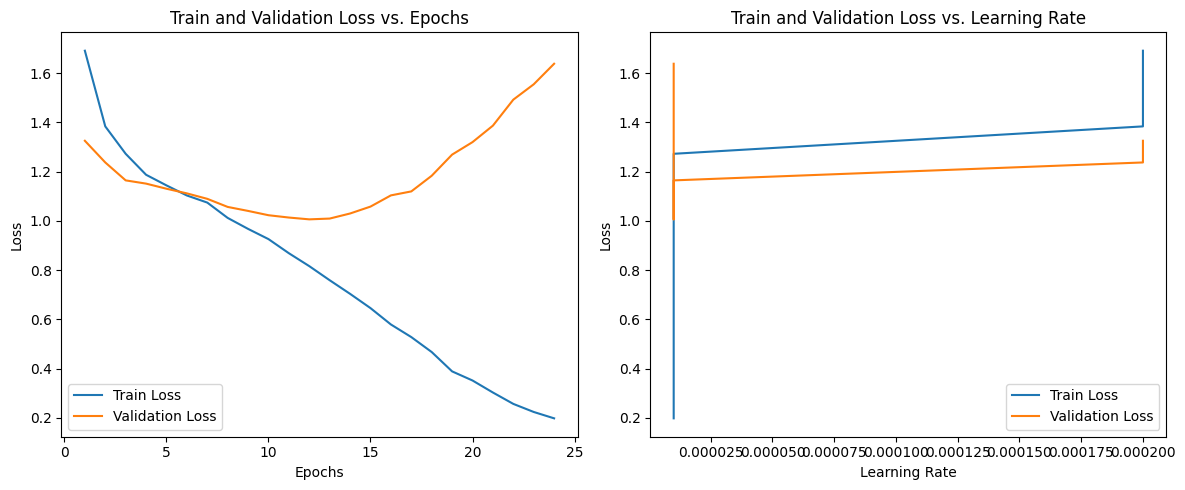

In [7]:
# Plotting
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot train and validation loss against epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss vs. Epochs')
plt.legend()

# Plot train and validation loss against learning rates
plt.subplot(1, 2, 2)
plt.plot(lr_list, train_losses, label='Train Loss')
plt.plot(lr_list, val_losses, label='Validation Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Train and Validation Loss vs. Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\zln92\AppData\Local\Temp\ipykernel_21644\1806678823.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_accuracies, y=category_names, ax=ax, palette='viridis')


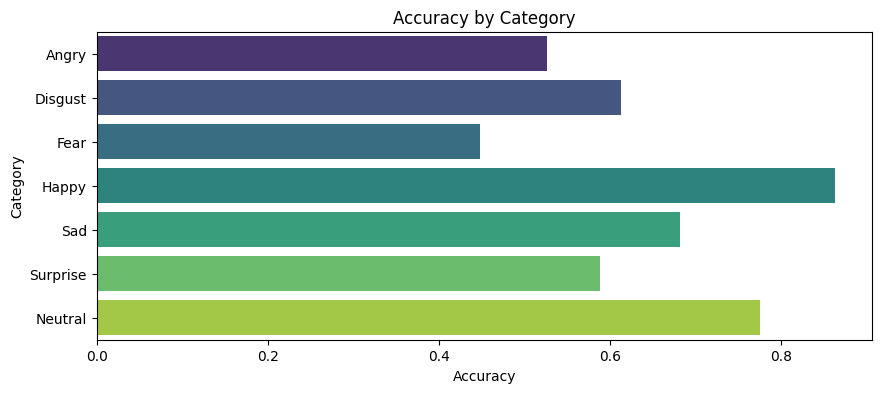

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score

def calculate_category_accuracies(model, dataloader, device, num_classes):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    category_accuracies = []
    for i in range(num_classes):
        category_mask = (np.array(true_labels) == i)
        category_acc = accuracy_score(np.array(true_labels)[category_mask], np.array(predicted_labels)[category_mask])
        category_accuracies.append(category_acc)

    return category_accuracies

category_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

category_accuracies = calculate_category_accuracies(model, test_loader, device, num_classes)

fig, ax = plt.subplots(figsize=(10, 4))  
sns.barplot(x=category_accuracies, y=category_names, ax=ax, palette='viridis')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Category')
ax.set_title('Accuracy by Category')
plt.show()

In [9]:
category_names, category_accuracies

(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
 [0.5260960334029228,
  0.6126126126126126,
  0.4482421875,
  0.8624577226606539,
  0.681265206812652,
  0.5878107457898958,
  0.7749699157641395])

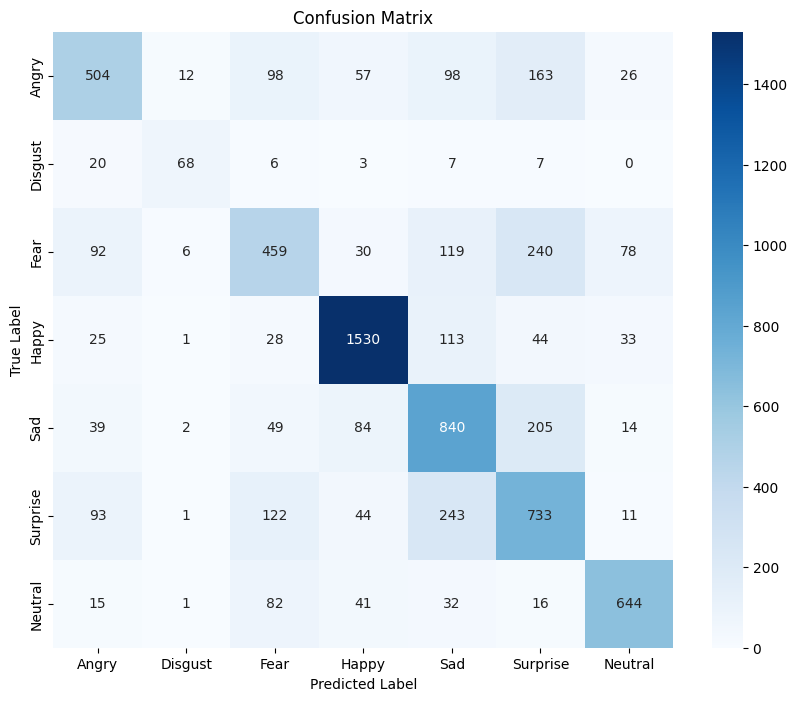

: 

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, device, num_classes, category_names):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, predicted_labels, labels=range(num_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

category_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plot_confusion_matrix(model, test_loader, device, num_classes, category_names)